# LOAD package

In [1]:
%pylab
from astropy.table import Table

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.integrate import quad,trapz
from scipy.special import gamma
from scipy.optimize import curve_fit

In [3]:
import seaborn as sns
sns.set()
# sns.set(rc={'figure.figsize':(15.7,9.27)})
# sns.set_style("ticks")

# Load data

## Load total nwp

### 直接观测结果

In [5]:
cen_bin = [11.4, 11.6,11.8]
sate_bin = [9.0, 9.5, 10.0, 10.5,11.0]
rvir = np.array([643.4968999301032,788.7737148534878 ])/1000

In [6]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
# r_need = r_need[4:-2]
number = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        data = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = data[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
        print(rp_new)
        
    
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

        
        
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        print("The number for each bin:")
        for k in range(len(rp_new)-1):
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k]
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number[i][j] = np.sum(N)
        
np.save("./all/original_num.npy",number)

[0.1        0.15848932 0.25118864 0.39810717 0.63095734 0.6434969 ]
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.21263139 1.1280089 ]
The nwp_new:
1.7092834337029292
the nwp_new:
[7.3033171  5.12528399 3.59928519 2.21263139 1.70928343]
The number for each bin:
0.34688793866751266
0.6114866451225076
1.0786618056384265
1.6656283749304979
0.08581641037410012
The total number:
3.7884811747330445
[0.1        0.15848932 0.25118864 0.39810717 0.63095734 0.6434969 ]
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.90231027 1.48025354]
The nwp_new:
2.242366969106104
the nwp_new:
[12.80349565  8.29585668  4.68147244  2.90231027  2.24236697]
The number for each bin:
0.6081316413439607
0.9897608758032768
1.4029801076909838
2.1848060012972628
0.11258044174292328
The total number:
5.298259067878408
[0.1        0.15848932 0.25118864 0.39810717 0.63095734 0.6434969 ]
The inter r:
0.6372271222051482
the inter rb

In [7]:
number

array([[ 3.78848117,  5.29825907,  4.73590265,  2.13285929],
       [ 6.83536664, 10.1963913 ,  9.13967322,  4.204876  ]])

In [6]:
number

array([[ 3.78848117,  5.29825907,  4.73590265,  2.13285929],
       [ 6.83536664, 10.1963913 ,  9.13967322,  4.204876  ]])

### 计算修正比例

In [69]:
r0 = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)


 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(nwp_new)
#         print("The length of rp:")
#         print(len(rp_new))
        print("The rp:")
        print(rp_new)
        print("The need_new:")
        print(r_need_new)
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

    
#         print("the nwp_new:")
#         print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


np.save("./all/corr_num.npy",number_new)

[0.56236571 2.02490825]
[0.0148269  0.06477922]
The length of nwp:
[107.99114322  67.36068408  42.0169805   26.20856179  16.34788371
   7.3033171    5.12528399   3.59928519   2.21263139   1.1280089 ]
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.6434969 ]
The need_new:
[0.01258925 0.01995262 0.03162278 0.05011872 0.07943282 0.12589254
 0.19952623 0.31622777 0.50118723 0.79432823]
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.21263139 1.1280089 ]
The nwp_new:
1.7092834337029292
The total number:
3.3608123547003896
[0.66229188 2.21526251]
[0.01679307 0.06867855]
The length of nwp:
[297.5867825  170.04393079  97.16472673  55.52085321  31.72514599
  12.80349565   8.29585668   4.68147244   2.90231027   1.48025354]
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.6434969 ]
The need_new:
[0.01258925 0.01995262 0.0

In [70]:
num0 = np.load("./all/original_num.npy")
num1 = np.load("./all/corr_num.npy")
fq_original = num1/num0

In [71]:
fq_original

array([[0.88711338, 1.0574677 , 1.0143623 , 0.96960425],
       [0.84980075, 1.02530869, 1.05586347, 0.88865407]])

## Load each field nwp

In [45]:
m_sate = [9.0,9.5,10.0,10.5,11.0]
#m_sate = np.linspace(9.0,11.7,28)
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
#m_sate = [9.5,10.0]
m_cen = [11.4,11.6,11.8]
#n = ['blue','red']
jack=50
zs = ['0p075','0p125','0p175']

num0 = np.load("./all/original_num.npy")
num1 = np.load("./all/corr_num.npy")
fq_original = num1/num0

number = np.zeros((2,4,50))
for i in range(len(m_cen)-1):
    for j in range(len(m_sate)-1):

        pcf = np.zeros((jack,len(r_need)))
        para1 = 0
        for k in range(len(zs)):
            data = np.load('/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC/%s_%.1f_%.1f_results_jack.npy' % (zs[k],m_cen[i],m_sate[j]))
            para = np.load('/home/yunzheng/PAC/code/PAC/0_0.2/sdss_PAC/%s_%.1f_%.1f_param_jack.npy' % (zs[k],m_cen[i],m_sate[j]))


            pcf += (data * para)
            para1 += para

        pcf = pcf/para1
        
        for q in range(50):
            
            index = np.searchsorted(r,rvir[i])-1
            print("The index rvir:")
            print(index)
            print(r[index])

            nwp_new = pcf[q][1:index+1]
            rp_new = np.hstack((r[1:index+1],rvir[i]))
            r_need_new = r_need[1:index+1]
            
            
            r_inter = (rp_new[-1] + rp_new[-2]) / 2.0
            print("The inter r:")
            print(r_inter)
            
            r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
            print("the inter rbin:")
            print(r_need_inter)
            nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
            print("the nwp interbin:")
            print(nwp_inter)
            
            
            f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
            nwp_inter0 = f(r_inter)
            nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
            print("The nwp_new:")
            print(nwp_new)
            
            
            N = np.empty(len(rp_new) - 1)
            for p in range(len(rp_new) - 1):
                print("The frac:")
                print(fq_original[i][j])
                N[p] = np.pi * (rp_new[p+1]**2-rp_new[p]**2) * nwp_new[p] * fq_original[i][j]
                
                
            print("The total number:")
            print(np.sum(N))
            
            number[i][j][q] = np.sum(N)
            

np.save("./all/eachfield_result.npy",number)

The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.22621091 1.13480216]
The nwp_new:
[7.30488252 5.25530706 3.64509308 2.22621091 1.71971361]
The frac:
0.8871133838845615
The frac:
0.8871133838845615
The frac:
0.8871133838845615
The frac:
0.8871133838845615
The frac:
0.8871133838845615
The total number:
3.3963512410548735
The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.22210925 1.12989215]
The nwp_new:
[7.41723138 5.14854639 3.66793608 2.22210925 1.71523682]
The frac:
0.8871133838845615
The frac:
0.8871133838845615
The frac:
0.8871133838845615
The frac:
0.8871133838845615
The frac:
0.8871133838845615
The total number:
3.392920095450088
The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.23572712 1.16287611]
The nwp_new:
[7.3350848  5.18534968 3.624404

In [12]:
pcf.shape

(50, 16)

In [17]:
data.shape

(50, 16)

In [34]:
number

array([[[3.04131341, 3.1226216 , 3.1324651 , 3.22078186, 3.15340048,
         3.05669255, 2.98386713, 2.93951199, 2.90514913, 3.07198651,
         2.94341832, 3.04430308, 3.04778177, 3.02479271, 3.0271125 ,
         3.14039144, 3.14631129, 3.04351829, 3.17019858, 3.09991387,
         3.16062075, 3.15577703, 3.06063077, 3.03328241, 3.10338952,
         3.15954884, 2.98062541, 3.09671089, 3.12027883, 3.04078271,
         3.14137526, 3.0678032 , 3.10900068, 3.02747906, 3.06860692,
         3.13366895, 3.04320411, 3.09101489, 3.11563568, 3.0870452 ,
         3.1913347 , 3.15395956, 3.15746374, 3.12143516, 3.00294468,
         3.05891553, 3.00437269, 3.15532198, 3.165382  , 3.14266117],
        [3.77136527, 3.74815024, 3.78815887, 3.78691733, 3.75948086,
         3.75571296, 3.71494005, 3.73363167, 3.70355963, 3.68582109,
         3.68642376, 3.64281869, 3.70528622, 3.73495502, 3.78170707,
         3.73027701, 3.76682599, 3.72926204, 3.78169038, 3.77597946,
         3.74509617, 3.72756631, 

In [28]:
pcf.shape

(50, 14)

In [46]:
pcf[2]

array([9.96782719e+00, 6.41921394e+00, 5.60987803e+00, 3.07566528e+00,
       1.93874539e+00, 9.64742884e-01, 6.26032666e-01, 3.82337873e-01,
       2.26862715e-01, 1.56275999e-01, 1.03587883e-01, 6.50426354e-02,
       3.51909700e-02, 1.80991126e-02, 1.12628477e-02, 9.36974273e-03])

# red galaxy

## all red galaxy

In [44]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
# r_need = r_need[4:-2]
number = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        data = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = data[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)
        
    
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

        
        
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        print("The number for each bin:")
        for k in range(len(rp_new)-1):
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k]
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number[i][j] = np.sum(N)
        
np.save("./red_galaxy/original_num.npy",number)

The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.05307684 0.45726405]
The nwp_new:
0.776574045792609
the nwp_new:
[5.14528061 3.27687231 1.99359918 1.05307684 0.77657405]
The number for each bin:
0.2443870036938731
0.39095661088048267
0.5974573238066573
0.7927369515160183
0.03898873392532755
The total number:
2.064526623822359
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.01531904 0.9610473 ]
The nwp_new:
1.5260561623771394
the nwp_new:
[10.80561904  6.81293753  3.70942923  2.01531904  1.52605616]
The number for each bin:
0.5132378704957563
0.8128369710892581
1.1116706290160419
1.517095256077457
0.07661728845096952
The total number:
4.031458015129483
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.19725442 1.13004347]
The nwp_new:
1.7019867603778456
the nwp_new:
[10.00368713  6.55889665  3.81302043  2.19725442  1.70198676]
The number for each bin:
0.47

## 修正比例

In [55]:
r0 = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)


 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
        print("The length of index in Rvir :")
        print(index)

        print("The original nwp:")
        print(nwp[1][:index+1])
        print("The original r:")
        print(nwp[0][:index+1])
        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The nwp:")
        print(nwp_new)
        print("The rp:")
        print(rp_new)
        print("The length of rp:")
#         print(len(rp_new))
        print("The rp_new:")
        print(r_need_new)
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

    
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


np.save("./red_galaxy/corr_num.npy",number_new)

[0.43121017 2.32642832]
[0.01356136 0.09733849]
The length of index in Rvir :
9
The original nwp:
[8.43160715 5.14528061 3.27687231 1.99359918 1.05307684 0.45726405
 0.1759886  0.08913842 0.04671883 0.04843632]
The original r:
[0.07943282 0.12589254 0.19952623 0.31622777 0.50118723 0.79432823
 1.25892541 1.99526231 3.16227766 5.01187234]
The nwp:
[164.92431373  89.53627497  48.60862753  26.38928938  14.3265636
   5.14528061   3.27687231   1.99359918   1.05307684   0.45726405]
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.6434969 ]
The length of rp:
The rp_new:
[0.01258925 0.01995262 0.03162278 0.05011872 0.07943282 0.12589254
 0.19952623 0.31622777 0.50118723 0.79432823]
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.05307684 0.45726405]
The nwp_new:
0.776574045792609
the nwp_new:
[164.92431373  89.53627497  48.60862753  26.38928938  14.3265636
   5.14528061   3.27687231  

In [56]:
number_new

array([[2.40262033, 4.89857576, 4.44613594, 1.99795869],
       [3.99615471, 9.5748355 , 9.03595948, 3.66224892]])

In [49]:
nwp[0][4:]

array([ 0.50118723,  0.79432823,  1.25892541,  1.99526231,  3.16227766,
        5.01187234,  7.94328235, 12.58925412, 19.95262315, 31.6227766 ,
       50.11872336, 79.43282347])

In [50]:
r0[5:]

array([  0.1       ,   0.15848932,   0.25118864,   0.39810717,
         0.63095734,   1.        ,   1.58489319,   2.51188643,
         3.98107171,   6.30957344,  10.        ,  15.84893192,
        25.11886432,  39.81071706,  63.09573445, 100.        ])

## Load each field

In [57]:
m_sate = [9.0,9.5,10.0,10.5,11.0]
#m_sate = np.linspace(9.0,11.7,28)
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
#m_sate = [9.5,10.0]
m_cen = [11.4,11.6,11.8]
#n = ['blue','red']
jack=50
zs = ['0p075','0p125','0p175']

num0 = np.load("./red_galaxy/original_num.npy")
num1 = np.load("./red_galaxy/corr_num.npy")
fq_original = num1/num0
print(fq_original)

number = np.zeros((2,4,50))
for i in range(len(m_cen)-1):
    for j in range(len(m_sate)-1):

        pcf = np.zeros((jack,len(r_need)))
        para1 = 0
        for k in range(len(zs)):
            data = np.load('/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red/%s_%.1f_%.1f_results_jack.npy' % (zs[k],m_cen[i],m_sate[j]))
            para = np.load('/home/yunzheng/PAC/code/PAC/0_0.2/color_cut_red/%s_%.1f_%.1f_param_jack.npy' % (zs[k],m_cen[i],m_sate[j]))


            pcf += (data * para)
            para1 += para

        pcf = pcf/para1


        
        for q in range(50):
            
            index = np.searchsorted(r,rvir[i])-1
            print("The index rvir:")
            print(index)
            print(r[index])

            nwp_new = pcf[q][1:index+1]
            rp_new = np.hstack((r[1:index+1],rvir[i]))
            r_need_new = r_need[1:index+1]
            
            
            r_inter = (rp_new[-1] + rp_new[-2]) / 2.0
            print("The inter r:")
            print(r_inter)
            
            r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
            print("the inter rbin:")
            print(r_need_inter)
            nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
            print("the nwp interbin:")
            print(nwp_inter)
            
            
            f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
            nwp_inter0 = f(r_inter)
            nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
            print("The nwp_new:")
            print(nwp_new)
            
            
            N = np.empty(len(rp_new) - 1)
            for p in range(len(rp_new) - 1):
                print("The frac:")
                print(fq_original[i][j])
                N[p] = np.pi * (rp_new[p+1]**2-rp_new[p]**2) * nwp_new[p] * fq_original[i][j]
                
                
            print("The total number:")
            print(np.sum(N))
            
            number[i][j][q] = np.sum(N)
            

np.save("./red_galaxy/eachfield_result.npy",number)
            

[[1.1637633  1.21508788 1.07397318 1.00238633]
 [1.02319862 1.17688354 1.10257727 0.90919088]]
The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.06565471 0.46955154]
The nwp_new:
[5.23733247 3.3563781  2.01648948 1.06565471 0.78901716]
The frac:
1.163763304406372
The frac:
1.163763304406372
The frac:
1.163763304406372
The frac:
1.163763304406372
The frac:
1.163763304406372
The total number:
2.4384769602992837
The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.06059183 0.4523603 ]
The nwp_new:
[5.17408393 3.33189764 2.0200678  1.06059183 0.77832579]
The frac:
1.163763304406372
The frac:
1.163763304406372
The frac:
1.163763304406372
The frac:
1.163763304406372
The frac:
1.163763304406372
The total number:
2.4277697808544847
The index rvir:
5
0.6309573444801934
The inter r:
0.6372271222051482
the inter rbin:
[0.50118723 0.79432823]


In [20]:
number

array([[[2.43847696, 2.42776978, 2.42969118, 2.39163732, 2.38824535,
         2.4173122 , 2.4191072 , 2.39464064, 2.4054613 , 2.38470823,
         2.42131751, 2.39675265, 2.38340615, 2.39533681, 2.38683383,
         2.37146336, 2.38313899, 2.38672801, 2.40050474, 2.38204152,
         2.39982086, 2.40266501, 2.40123644, 2.37168595, 2.38535117,
         2.39206935, 2.41658084, 2.41762306, 2.39601538, 2.37992403,
         2.38048084, 2.40606512, 2.37914843, 2.41859958, 2.39714123,
         2.42339361, 2.40056792, 2.41276301, 2.38316285, 2.39715703,
         2.4085923 , 2.39232447, 2.37300798, 2.40949398, 2.3930739 ,
         2.42066253, 2.34755028, 2.48324048, 2.47374472, 2.4633002 ],
        [4.96133764, 4.920339  , 4.96837919, 4.87517884, 4.89960771,
         4.98031065, 4.91635631, 4.87879397, 4.85580858, 4.85246629,
         4.9119877 , 4.90757996, 4.88003534, 4.90002904, 4.83979592,
         4.87078887, 4.87875438, 4.88920871, 4.88211796, 4.87829429,
         4.87061309, 4.89673439, 

# 计算均值和方差

In [58]:
red_num = np.load("./red_galaxy/eachfield_result.npy")
all_num = np.load("./all/eachfield_result.npy")

In [22]:
red_num.shape

(2, 4, 50)

In [59]:
result = np.sum(red_num / all_num,axis = 2) / 50

In [60]:
result

array([[0.71489102, 0.87431574, 0.92552235, 0.96611868],
       [0.68795075, 0.91586171, 0.9363417 , 0.98008094]])

In [61]:
sigma = np.sqrt(49) * np.std(red_num / all_num,axis = -1) 

In [62]:
sigma

array([[0.02190485, 0.01246833, 0.00639704, 0.00601624],
       [0.03259592, 0.01947871, 0.01093419, 0.0074678 ]])

In [27]:
a = np.load("./result.npy")

In [28]:
a[1][0]

array([0.01793433, 0.01132279, 0.00596038, 0.00758776])

In [63]:
np.save("./result.npy",np.array([result,sigma]))

# 结果比较

In [23]:
TNG = np.load("./TNG_fq.npz")

In [33]:
TNG['version2']

array([[0.78626209, 0.71118531, 0.70704961, 0.88346883],
       [0.85262374, 0.78945016, 0.81434355, 0.92370572],
       [0.89636608, 0.84752892, 0.85514019, 0.94760479]])

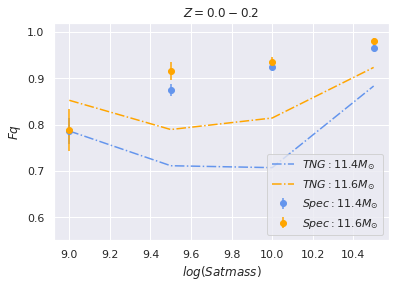

In [72]:
cen_bin = [11.4, 11.6,11.8]
sate_bin = [9.0,9.5, 10.0, 10.5,11.0]
color0 = ['cornflowerblue','orange']   #######e','seagreen',
for i in range(2):
    for j in range(4):
       
        if j==0:
            continue
        data = np.load("./result.npy")
        plt.errorbar(sate_bin[j],data[0][i][j],data[1][i][j],color = color0[i],fmt = 'o')

data = np.load("./result_test.npy")
plt.errorbar(sate_bin[0],data[0][0][0],data[1][0][0],color = color0[0],fmt = 'o',label = "$Spec : %s M_{\odot}$"%cen_bin[0])
plt.errorbar(sate_bin[0],data[0][1][0],data[1][1][0],color = color0[1],fmt = 'o',label = "$Spec : %s M_{\odot}$"%cen_bin[1])


TNG = np.load("./TNG_fq.npz")
plt.plot(sate_bin[:-1],TNG['version2'][0],color = color0[0],linestyle = '-.',label = "$TNG : 11.4 M_{\odot}$")
plt.plot(sate_bin[:-1],TNG['version2'][1],color = color0[1],linestyle = '-.',label = "$TNG : 11.6 M_{\odot}$")


plt.xlabel("$log(Sat mass)$")
plt.ylabel("$Fq$")
plt.legend(loc = "lower right")
plt.title("$Z = 0.0 - 0.2$")
plt.ylim(0.55,1.02)
# plt.plot()
plt.savefig("/home/yunzheng/PAC/picture/PCF_colorcut/Fq_0.1.pdf",dpi = 100)